# DCGAN
* source of inspiration
https://github.com/shriyutha/Monet-paintings-DCGAN-Deeplearning/blob/main/monet-painting-gan-4.ipynb  

In [1]:
!pip install pandas


In [2]:
!pip install scipy


In [3]:
!pip install seaborn


In [ ]:
import numpy as np
import pandas as pd
import random
import shutil
import glob
import os
from scipy import stats
import time


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
import tensorflow_addons  as tfa
from tensorflow.keras import Sequential, Model, layers, regularizers
from tensorflow.keras.layers import Conv2D, Dense, Input, Dropout, Activation, LeakyReLU, ReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.activations import relu, tanh
from keras.initializers import RandomNormal

In [5]:
Chinese_landscape_jpg_path = r'E:\ual\chinese landscape painting\*.jpg'
photo_jpg_path = r'E:\ual\photo\*.jpg'

In [6]:
# Loading an image files by its path:
def Load_Image(path):
    image_path = tf.io.read_file(path)
    image_path = tf.image.decode_image(image_path, channels = 3)
    image_path = tf.image.convert_image_dtype(image_path, tf.float32)
    image_path = tf.reshape(image_path, [256, 256, 3])
    return image_path


# The function below decode image, rescales and reshape the images: 
def Decode_Image(path):
    images = tf.image.decode_image(path, channels = 3)
    images = (tf.cast(images, tf.float32) /127.5) - 1
    images = tf.reshape(images, [256, 256, 3])
    return images


# The function below decode image, rescales and reshape the images: 
def Process_Image(path):
    format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),\
        'image' : tf.io.FixedLenFeature([], tf.string),\
        'target' : tf.io.FixedLenFeature([], tf.string) }
    
    paths = tf.io.parse_single_example(path, format)
    image = Decode_Image(paths['image'])
    return image


# Loads the whole dataset to a tensorflow dataset object:
def Load_Data(name):
    dataset = tf.data.TFRecordDataset(name)
    dataset = dataset.map(Process_Image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return dataset


# To crop the images:
def Crop_Image(image, box):
    img = Image.open(image)
    img = img.crop(box)
    return img

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import tensorflow as tf

def load_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Scale image pixel values to [0, 1] range
    return image

# Load Chinese landscape painting images
Chinese_landscape_image_paths = ['E:/ual/chinese landscape painting/{}'.format(filename) for filename in os.listdir('E:/ual/chinese landscape painting/')]
Chinese_landscape_images = [load_image(path) for path in Chinese_landscape_image_paths]

# Load photo images
photo_image_paths = ['E:/ual/photo/{}'.format(filename) for filename in os.listdir('E:/ual/photo/')]
photo_images = [load_image(path) for path in photo_image_paths]

# Convert to TensorFlow Dataset
Chinese_landscape_data = tf.data.Dataset.from_tensor_slices(Chinese_landscape_images)
photo_data = tf.data.Dataset.from_tensor_slices(photo_images)

# Split datasets into batches
Chinese_landscape_data = Chinese_landscape_data.batch(1)
photo_data = photo_data.batch(1)



(-0.5, 255.5, 255.5, -0.5)

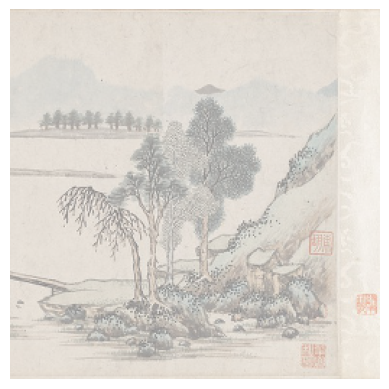

In [8]:
# Visualization:

sample = next(iter(Chinese_landscape_data))
plt.imshow(sample[0]*0.5 + 0.5)
plt.axis('off')

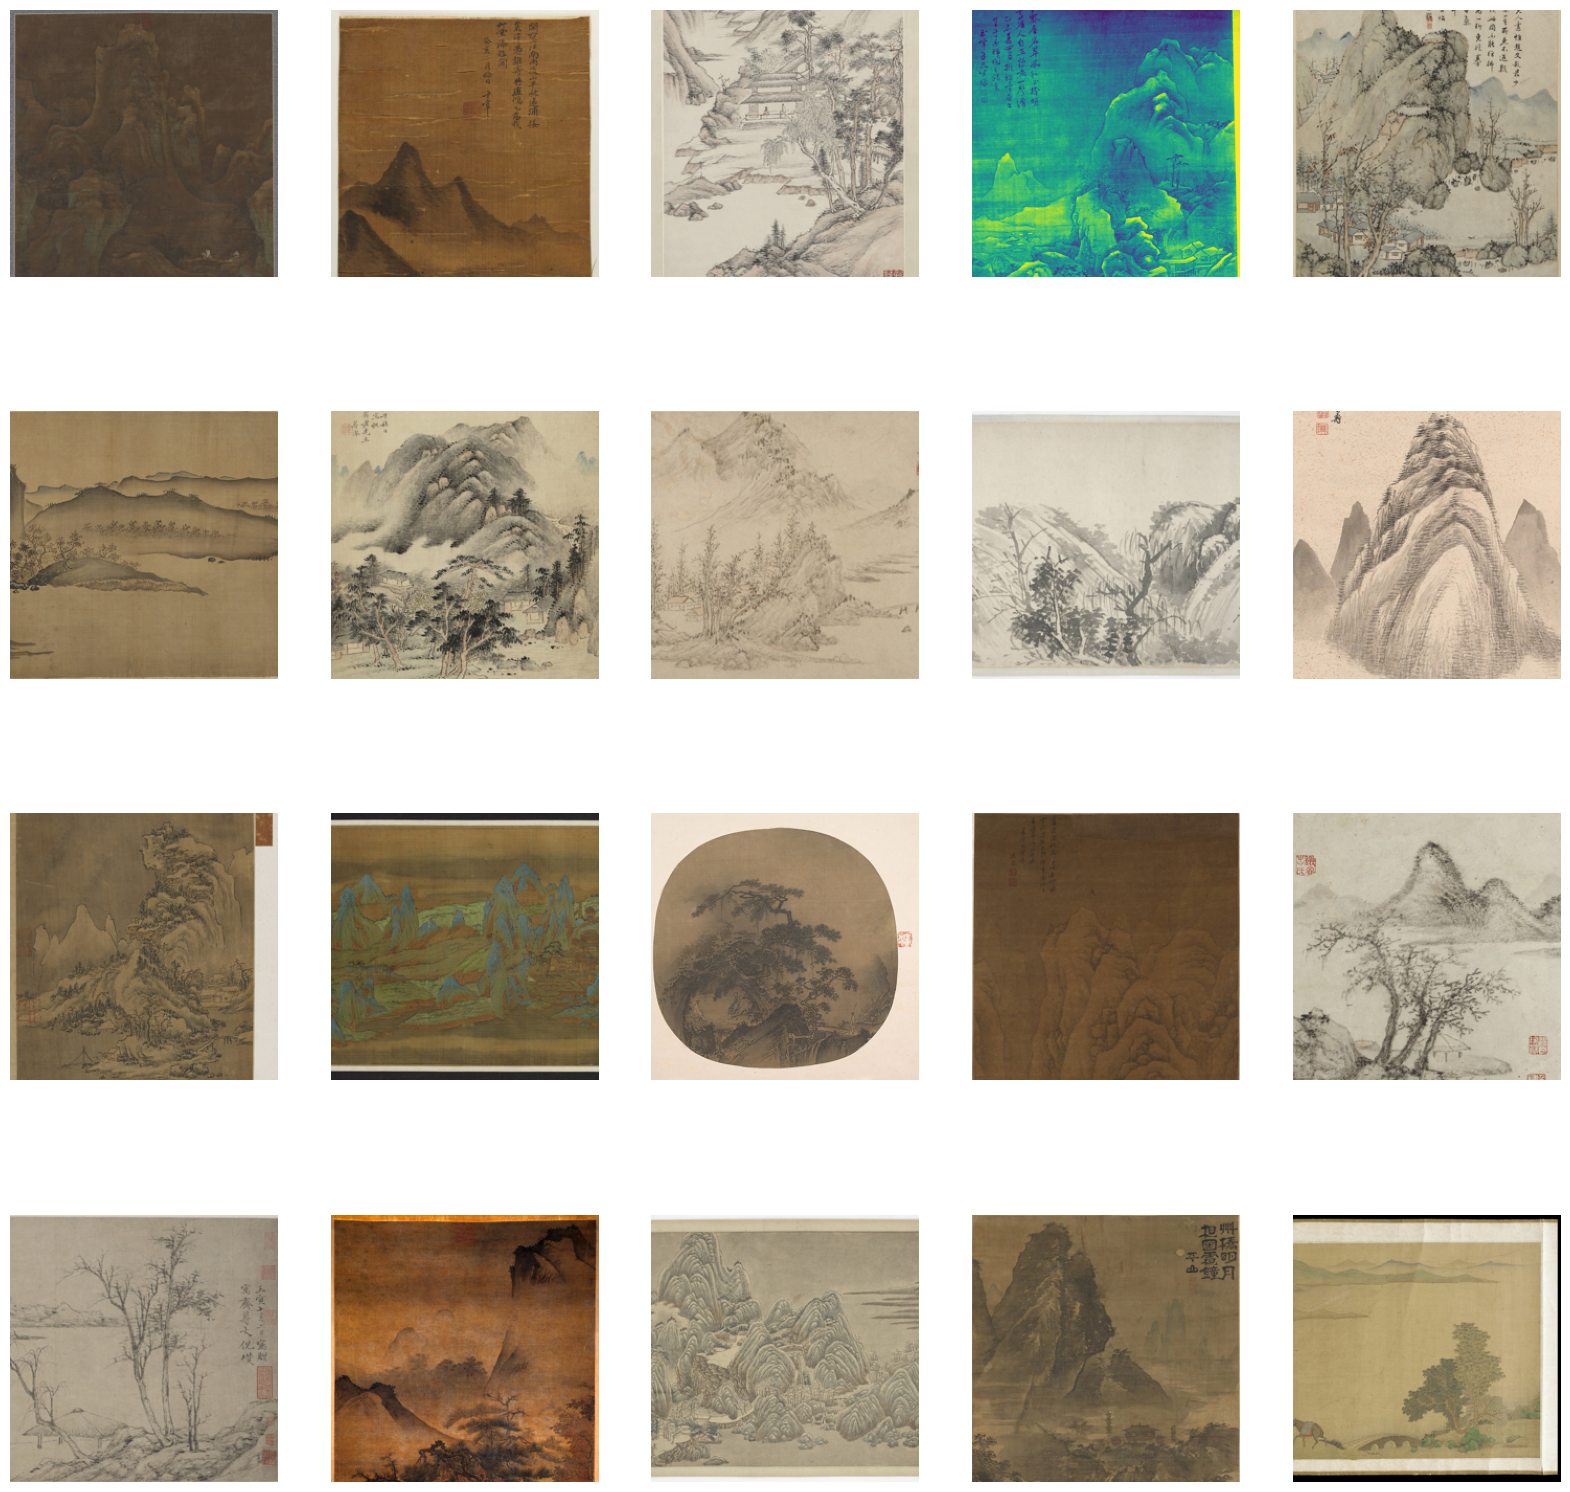

In [9]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

def load_image(image_path):
    with open(image_path, 'rb') as f: 
        image = Image.open(io.BytesIO(f.read()))
        image = image.resize((256, 256)) 
        return np.array(image) / 255.0

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
Chinese_landscape_jpg = tf.io.gfile.glob(r'E:\ual\chinese landscape painting\*.jpg')  
jpg = random.sample(Chinese_landscape_jpg, min(len(Chinese_landscape_jpg), 20))  

for idx, name in enumerate(jpg):
    img = load_image(name)
    ax[idx // 5, idx % 5].imshow(img)
    ax[idx // 5, idx % 5].axis('off')  
plt.show()


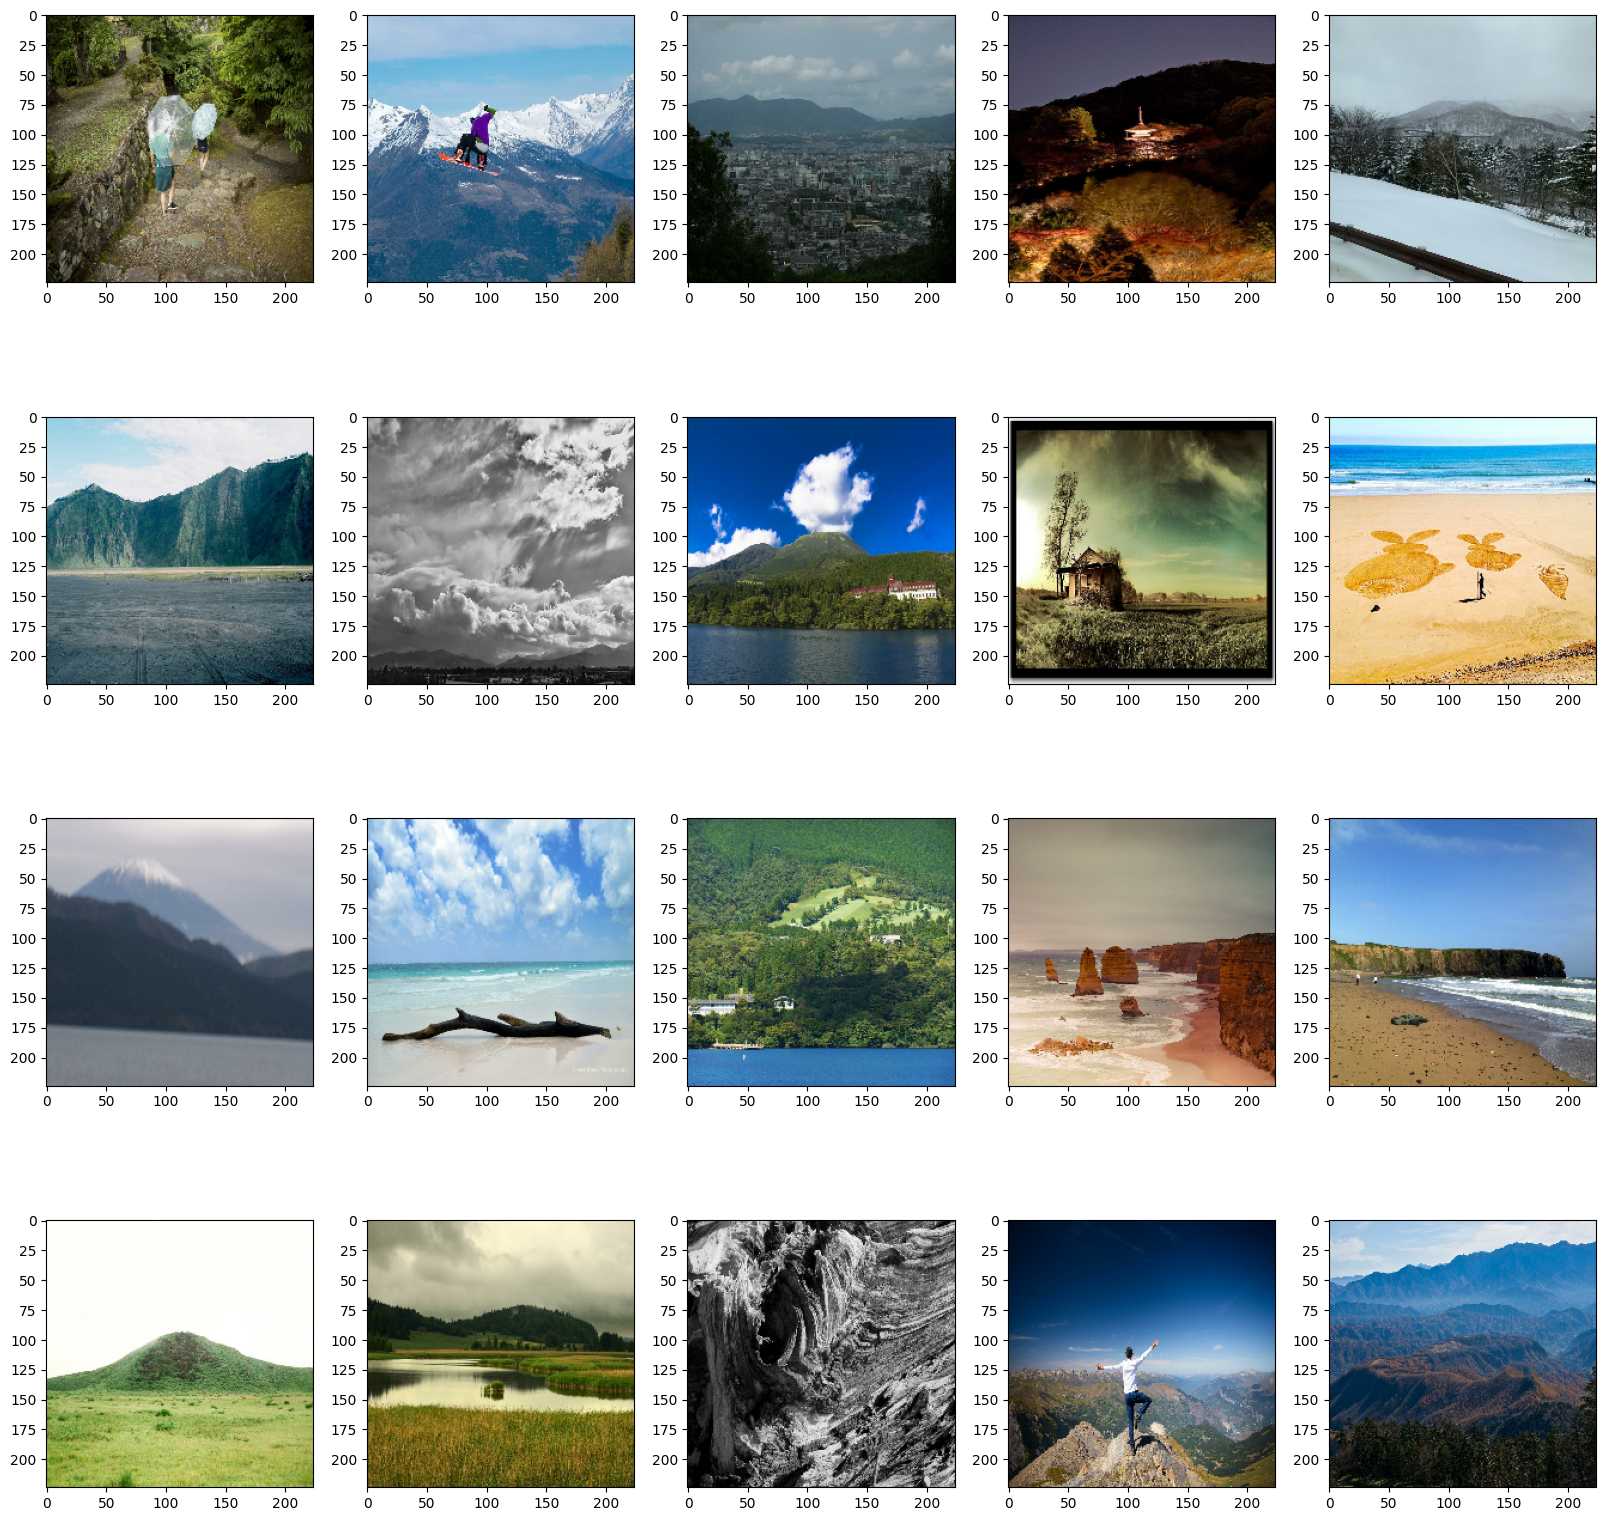

In [10]:
def Load_Image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])  # Set the desired height and width
    return image

fig, ax = plt.subplots(4, 5, figsize = (20, 20))

photo_jpg = tf.io.gfile.glob(r'E:\ual\photo\*.jpg')

jpg = random.sample(photo_jpg, 20)

for idx, name in enumerate(jpg):
    img = Load_Image(name)
    ax[idx//5, idx%5].imshow(img)

In [11]:
# Create a function to build the generator model:

def generator_model():
    initializer  = RandomNormal(mean = 0, stddev = 0.02)
    
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, input_shape = [256, 256, 3], kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #model.add(Reshape((8, 8, 512)))

    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))


    model.add(Conv2DTranspose(filters = 265, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    return model


In [12]:
# Create a function to build the discriminator model:

def discriminator_model():
    initializer  = RandomNormal(mean = 0, stddev = 0.02)
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2,2), padding = 'same', input_shape = [256,256,3], kernel_initializer = initializer, use_bias = False))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 1, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.add(Flatten())
       
    return model

In [13]:
# Summary:

optimizer = Adam(0.0001)
generator = generator_model()
generator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
generator.summary() 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3072      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)      

c:\Users\92919\miniconda3\envs\aim\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [14]:
# Summary:

discriminator = discriminator_model()
discriminator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      3072      
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 128)       0         
                                                      

In [15]:
# Combining both generator and discriminatir:

optimizer = Adam(0.0001)

def gan_model(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


generator = generator_model()
discriminator = discriminator_model()

GAN = gan_model(generator, discriminator)
GAN.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
GAN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       2296112   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 664581    
                                                                 
Total params: 2960693 (11.29 MB)
Trainable params: 2958107 (11.28 MB)
Non-trainable params: 2586 (10.10 KB)
_________________________________________________________________


(1, 256, 256, 3)
(256, 256)


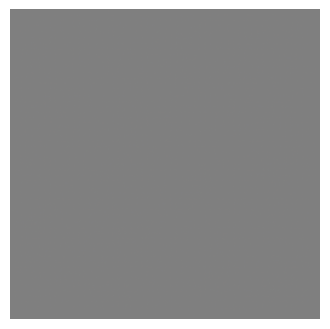

In [16]:

# Visualize one sample example and make sure its working correct:

noise = tf.random.normal([1,256, 256, 3])
image = generator(noise)
generated_image = generator(noise, training = False)
print(generated_image.shape)
print(generated_image[0, :, :, 0].shape)

def generate_images(row = 1,col = 1, is_norm = False):
    plt.figure(figsize = (4*row, 5*col))    
    for ele in range(1,1+row*col):        
        noise = tf.random.normal([1, 256, 256, 3])
        plt.subplot(row, col, ele)
        if(is_norm):
            plt.imshow(generator(noise)[0, :, :, :]*255)
        else:            
            plt.imshow(generator(noise)[0, :, :, :]*0.5 + 0.5)
        plt.axis('off')
        
generate_images()

In [17]:
discriminator = discriminator_model()
gen_pred = discriminator(generated_image, training = False)
print(gen_pred)

tf.Tensor([[0.5000034]], shape=(1, 1), dtype=float32)


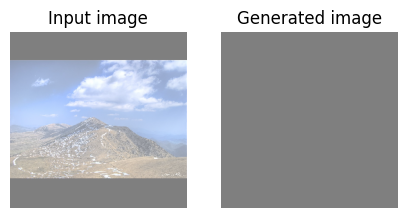

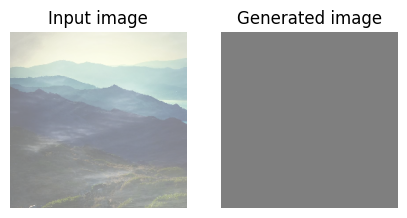

In [18]:
df = iter(photo_data)
for ele in range(2):
        example_sample = next(df)
        generated_sample = generator(example_sample)
        
        f = plt.figure(figsize=(5, 5))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [19]:
# Create two separate loss functions for the generator and discriminator:

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# Set the hyperparameters to be used for training:

EPOCHS = 100
sample_interval = EPOCHS / 10
BATCH_SIZE = 32

In [21]:
# Create a function that trains one step of a GAN:
@tf.function
def train_step(image_batch):
    noise = tf.random.normal([1,256, 256, 3])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        
        generated_image = generator(noise, training=True)

        discriminator_pred_gen = discriminator(generated_image, training=True)

        discriminator_pred_ori= discriminator(image_batch, training=True)


        discriminator_loss = cross_entropy(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
        generator_loss = cross_entropy(tf.ones_like(discriminator_pred_gen), discriminator_pred_gen)
        
    generator_grad = gen_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
    optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))   

In [22]:
# Create a function that trains the GAN on multiple epochs:

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        print(f"Time for epoch {epoch+ 1} is : {time.time()-start}")

In [23]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0001)  # Defining the Optimizer

train(Chinese_landscape_data, EPOCHS)



Time for epoch 1 is : 358.6257140636444
Time for epoch 2 is : 347.998188495636
Time for epoch 3 is : 354.70160579681396
Time for epoch 4 is : 348.5549371242523
Time for epoch 5 is : 349.4497046470642
Time for epoch 6 is : 342.2062268257141
Time for epoch 7 is : 341.4630630016327
Time for epoch 8 is : 334.1839790344238
Time for epoch 9 is : 337.3352997303009
Time for epoch 10 is : 339.4503426551819
Time for epoch 11 is : 335.82288360595703
Time for epoch 12 is : 336.0192725658417
Time for epoch 13 is : 335.8178975582123
Time for epoch 14 is : 336.7024390697479
Time for epoch 15 is : 335.8054029941559
Time for epoch 16 is : 338.11574697494507
Time for epoch 17 is : 338.0696973800659
Time for epoch 18 is : 338.2234148979187
Time for epoch 19 is : 341.03899693489075
Time for epoch 20 is : 346.73918628692627
Time for epoch 21 is : 335.6620693206787
Time for epoch 22 is : 335.3962609767914
Time for epoch 23 is : 335.39559745788574
Time for epoch 24 is : 335.98477363586426
Time for epoch 25 i

In [24]:
import PIL
from PIL import Image
SAVE_PATH = 'E:\\ual\\out Chinese landscape painting2'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
else:
    shutil.rmtree(SAVE_PATH)
    os.mkdir(SAVE_PATH)

for index, photo in enumerate(photo_data):
    prediction = generator(photo, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    PIL.Image.fromarray(prediction).save(os.path.join(SAVE_PATH, f'image{index+1}.jpg'))

shutil.make_archive('images', 'zip', SAVE_PATH)

'c:\\Users\\92919\\Desktop\\images.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


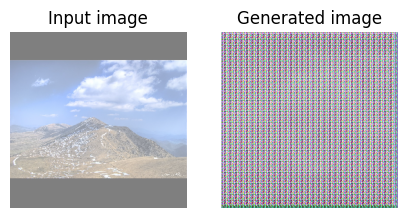

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


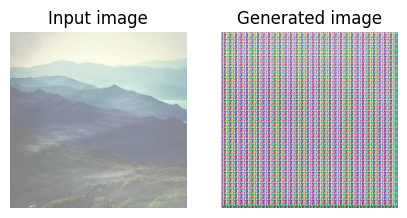

In [26]:
ds_iter = iter(photo_data)
for n_sample in range(2):
        example_sample = next(ds_iter)
        generated_sample = generator(example_sample)
        
        f = plt.figure(figsize=(5, 5))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()